# Tensorflow Feed Forward Neural Network

A fully connected feed forward neural network written in pure tensorflow.

## Imports

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from fetch_mnist import fetch_mnist

np.random.seed(1)

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
num_pixels = width*height

# Training Parameters
num_steps = 2000   # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 100 # Stochastic Gradient Descent batch size

# NN Parameters
num_hidden1 = 2048 # Convolutional Kernel size
num_hidden2 = 1024 # Convolutional Kernel depth size == Number of Convolutional Kernels

# Optimization parameters
learning_rate = 0.001 # Learning rate

## Data

We use the custom MNIST data fetcher from `fetch_mnist.py`.

As a preprocessing step, the labels are converted to a one-hot encoded sparse matrix. [One hot encoding](https://en.wikipedia.org/wiki/One-hot) is just a way of replacing each integer in the label vector with a row of zeros, except at the position specified by the integer, where you put a 1.

Note that the inverse transformation of the one-hot encoding can always be performed by taking the `argmax` along `axis=1`.

Secondly, the image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In [3]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = np.int32(data[:,0])
    labels_onehot = np.zeros((len(labels), num_labels))
    labels_onehot[np.arange(len(labels)),labels] = 1
    values = np.float32(data[:,1:])/255
    return values, labels, labels_onehot

train_values, train_labels, train_labels_onehot = get_values_labels(train_data)
valid_values, valid_labels, valid_labels_onehot = get_values_labels(valid_data)
test_values, test_labels, test_labels_onehot = get_values_labels(test_data)

print(f'train data shape:\t\t{train_values.shape}')
print(f'train labels (one-hot) shape:\t{train_labels_onehot.shape}')

train data shape:		(50000, 784)
train labels (one-hot) shape:	(50000, 10)


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

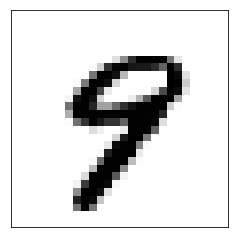

In [4]:
def show_digit(digit_array):
    plt.imshow(digit_array.reshape(height, width), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Model

We choose a 4 layered network consisting of 2 convolutional layers with weights and biases (w1, b1) and (w2,b2), followed by a fully connected hidden layer (w3,b3) with `num_hidden` hidden neurons and an output layer (w4, b4) with `num_labels` output nodes (one-hot encoding).

We initialize the weights and biases such that the kernel size of the second convolutional layer is twice that of the kernel size of the first convolutional layer.



We use the categorical cross entropy loss for training the model.

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like Adam or RMSProp


In [5]:
class Model:
    def __init__(self):
        # inputs
        self.data = tf.placeholder(tf.float32, shape=(None, num_pixels))
        self.labels = tf.placeholder(tf.float32, shape=(None, num_labels))
        
        # weights & biases
        self.w1 = tf.Variable(tf.truncated_normal([num_pixels, num_hidden1], stddev=0.1))
        self.b1 = tf.Variable(tf.zeros([num_hidden1]))
        self.w2 = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
        self.b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
        self.w3 = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
        self.b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        
        # Fully Connected Layer 1
        x = tf.nn.relu(tf.matmul(self.data, self.w1) + self.b1)
        
        # Fully Connected Layer 2
        x = tf.nn.relu(tf.matmul(x, self.w2) + self.b2)
        
        # Fully Connected Layer 2
        logits = tf.matmul(x, self.w3) + self.b3
        
        # prediction
        self.pred = tf.nn.softmax(logits)

        # loss
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=self.labels))

        # accuracy
        self.acc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.labels, 1))))

        # optimizer
        self.opt = tf.train.RMSPropOptimizer(learning_rate).minimize(self.loss)

        # initializer
        self.init = tf.global_variables_initializer()

# Train

Create the model

In [6]:
model = Model()

Open the session

In [7]:
session = tf.Session()
session.run(model.init)

Run the session

In [8]:
%%time
history = [] 
for step in range(num_steps):
    idxs = np.random.randint(0, train_size, batch_size)

    if step%(train_size//batch_size) == 0 or step == num_steps -1:
        fd={model.data:valid_values, model.labels:valid_labels_onehot}
        val_acc, val_loss = session.run([model.acc, model.loss], feed_dict=fd)
        history.append((step, val_loss, val_acc))
        print(f'Step {step:5.0f}\t Valid. Acc. = {val_acc:5.2f}')
        
    session.run(model.opt, feed_dict={model.data:train_values[idxs], model.labels:train_labels_onehot[idxs]})

Step     0	 Valid. Acc. =  9.95
Step   500	 Valid. Acc. = 90.93
Step  1000	 Valid. Acc. = 96.32
Step  1500	 Valid. Acc. = 96.93
Step  1999	 Valid. Acc. = 96.96
CPU times: user 5.46 s, sys: 1.25 s, total: 6.7 s
Wall time: 6.14 s


Training history:

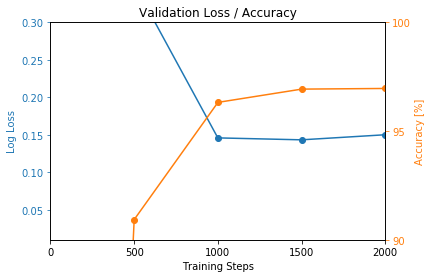

In [9]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(96,100)
plt.yticks([90,95,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
plt.ylim(0.01, 0.3)

plt.xlim(0, max(steps))
plt.xticks([0,num_steps//4, num_steps//2, 3*num_steps//4, num_steps])
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

# Test

Finally, the accuracy on the test set can be evaluated:

In [10]:
fd = {model.data:test_values, model.labels:test_labels_onehot}
test_accuracy = session.run(model.acc, feed_dict=fd)
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 97.54


Visualize an example

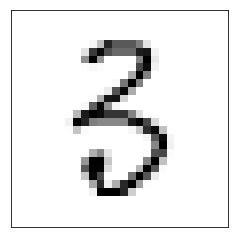

prediction=3	target=3


In [11]:
N = 315
show_digit(test_values[N])
prediction = np.argmax(session.run(model.pred, feed_dict={model.data:test_values[N:N+1]}).ravel())
print(f'prediction={prediction}\ttarget={test_labels[N]}')

Close the session

In [12]:
session.close()